## Εισαγωγικά

In [1]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch


In [2]:
# Set random seed for reproducibility
import random
import os
def set_all_seeds(seed=56):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    g = torch.Generator()
    g.manual_seed(seed)
    return g

from sklearn.utils import check_random_state
check_random_state(seed=56)

RandomState(MT19937) at 0x1CA3C1D1B40

In [3]:
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


## Β. Προεπεξεργασία και Εξερεύνηση Δεδομένων

### 1. Εξερευνητική Ανάλυση Δεδομένων (EDA)

In [4]:
# Load data with pickling enabled
data = np.load(r'C:\\Users\\vasgk\\Desktop\\Μηχανική μάθηση\\Data\\breastmnist_224.npz', allow_pickle=True)

# Inspect the keys in the dataset
print("Keys in the dataset:", data.files)
print("Shape of file contents: (no of contents, dimensions (224x224))")

# Print the shape of each file in the original npz file
for key in data.files:
    print(f"{key}: {data[key].shape}")

Keys in the dataset: ['train_images', 'train_labels', 'val_images', 'val_labels', 'test_images', 'test_labels']
Shape of file contents: (no of contents, dimensions (224x224))
train_images: (546, 224, 224)
train_labels: (546, 1)
val_images: (78, 224, 224)
val_labels: (78, 1)
test_images: (156, 224, 224)
test_labels: (156, 1)


In [5]:
# Convert the data into a DataFrame
# Flatten the images and combine them with labels
# Flatten the images and combine them with labels
train_images_flat = data['train_images'].reshape(len(data['train_images']), -1)  # Flatten 224x224 images
df_train = pd.DataFrame(train_images_flat)
df_train['Label'] = data['train_labels']

# Repeat for validation and test data, but in reverse order because the dataset's ratio is reversed
val_images_flat = data['test_images'].reshape(len(data['test_images']), -1)
df_val = pd.DataFrame(val_images_flat)
df_val['Label'] = data['test_labels']

test_images_flat = data['val_images'].reshape(len(data['val_images']), -1)
df_test = pd.DataFrame(test_images_flat)
df_test['Label'] = data['val_labels']

# Split the data into features and labels for the rest of the code
x_train = df_train.drop(columns=['Label']).values  
y_train = df_train['Label'].values.ravel()  
x_val = df_val.drop(columns=['Label']).values 
y_val = df_val['Label'].values.ravel()  
x_test = df_test.drop(columns=['Label']).values  
y_test = df_test['Label'].values.ravel()  

## Ε. Βαθιά Νευρωνικά Δίκτυα

### CNN


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Μετατροπή ετικετών σε αριθμούς
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

height, width = 224, 224
X_train_tensor = torch.tensor(x_train.reshape(-1, 1, height, width), dtype=torch.float32)
X_val_tensor = torch.tensor(x_val.reshape(-1, 1, height, width), dtype=torch.float32)
X_test_tensor = torch.tensor(x_test.reshape(-1, 1, height, width), dtype=torch.float32)

train_data = TensorDataset(X_train_tensor, torch.tensor(y_train_encoded, dtype=torch.long))
val_data = TensorDataset(X_val_tensor, torch.tensor(y_val_encoded, dtype=torch.long))
test_data = TensorDataset(X_test_tensor, torch.tensor(y_test_encoded, dtype=torch.long))

class CNN(nn.Module):
    def __init__(self, num_classes, activation_fn='ReLU'):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
        if activation_fn == 'ReLU':
            self.activation = nn.ReLU()
        elif activation_fn == 'LeakyReLU':
            self.activation = nn.LeakyReLU(0.1)
        elif activation_fn == 'ELU':
            self.activation = nn.ELU()
        else:
            raise ValueError(f"Unknown activation function: {activation_fn}")
        self.maxpool = nn.MaxPool2d(2)
    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.maxpool(x)
        x = self.activation(self.conv2(x))
        x = self.maxpool(x)
        x = self.activation(self.conv3(x))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.activation(self.fc1(x)))
        x = self.fc2(x)
        return x

def create_model_and_optimizer(activation_fn='ReLU', lr=0.001, weight_decay=0.01):
    model = CNN(num_classes=len(np.unique(y_train)), activation_fn=activation_fn)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    return model, criterion, optimizer

def evaluate_and_plot(model, X_tensor, y_true, class_names, device, set_name="Set"):
    model.eval()
    X_tensor = X_tensor.to(device)
    y_true_tensor = torch.tensor(y_true, dtype=torch.long).to(device)
    with torch.no_grad():
        outputs = model(X_tensor)
        loss = nn.CrossEntropyLoss()(outputs, y_true_tensor).item()
        _, predicted = torch.max(outputs, 1)
    y_pred = predicted.cpu().numpy()
    y_true = y_true_tensor.cpu().numpy()
    acc = (y_pred == y_true).mean() * 100
    recall_0 = recall_score(y_true, y_pred, pos_label=0, average='binary')
    print(f"\n{set_name} Loss: {loss:.4f}, Accuracy: {acc:.2f}%, Recall 0: {recall_0:.4f}")
    print(classification_report(y_true, y_pred, target_names=class_names))
    # Confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{set_name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    # ROC curve
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))
    probs = torch.softmax(outputs, dim=1).cpu().numpy()
    plt.figure(figsize=(6,5))
    if len(class_names) == 2:
        fpr, tpr, _ = roc_curve(y_true_bin.ravel(), probs[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    else:
        for i in range(len(class_names)):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC={roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{set_name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Υπερπαράμετροι
learning_rates = [0.001, 0.0001]
activation_functions = ['ReLU', 'LeakyReLU', 'ELU']
weight_decays = [0.01, 0.001]

# Για να κρατήσουμε το καλύτερο μοντέλο συνολικά για κάθε metric
overall_best = {
    "acc": {"score": 0, "state": None, "params": None, "history": None},
    "recall0": {"score": 0, "state": None, "params": None, "history": None},
    "custom": {"score": 0, "state": None, "params": None, "history": None},
}

for lr in learning_rates:
    for activation_fn in activation_functions:
        for wd in weight_decays:
            g = set_all_seeds(seed=56)
            train_loader = DataLoader(train_data, batch_size=32, shuffle=True, generator=g)
            val_loader = DataLoader(val_data, batch_size=32, shuffle=False, generator=g)
            test_loader = DataLoader(test_data, batch_size=32, shuffle=False, generator=g)
            print(f"\nTraining with lr={lr}, activation_fn={activation_fn}, weight_decay={wd}")
            model, criterion, optimizer = create_model_and_optimizer(activation_fn, lr, wd)
            model.to(device)
            best_acc, best_recall0, best_custom = 0, 0, 0
            best_acc_state, best_recall0_state, best_custom_state = None, None, None
            best_acc_history, best_recall0_history, best_custom_history = None, None, None
            train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
            val_recalls_0, val_custom_scores = [], []
            num_epochs = 20
            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                correct = 0
                total = 0
                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                train_accuracy = 100 * correct / total
                train_losses.append(running_loss / len(train_loader))
                train_accuracies.append(train_accuracy)
                # Validation
                model.eval()
                val_loss = 0.0
                val_correct = 0
                val_total = 0
                val_preds, val_targets = [], []
                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        val_loss += loss.item()
                        _, predicted = torch.max(outputs, 1)
                        val_total += labels.size(0)
                        val_correct += (predicted == labels).sum().item()
                        val_preds.extend(predicted.cpu().numpy())
                        val_targets.extend(labels.cpu().numpy())
                val_accuracy = 100 * val_correct / val_total
                val_losses.append(val_loss / len(val_loader))
                val_accuracies.append(val_accuracy)
                val_recall0 = recall_score(val_targets, val_preds, pos_label=0, average='binary')
                val_custom = 0.7 * val_recall0 + 0.3 * (val_accuracy / 100)
                val_recalls_0.append(val_recall0)
                val_custom_scores.append(val_custom)
                print(f"Epoch {epoch+1}/{num_epochs} | "
                    f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.2f}% | "
                    f"Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_accuracies[-1]:.2f}% | "
                    f"Val Recall0: {val_recalls_0[-1]:.4f} | Val Custom: {val_custom_scores[-1]:.4f}")
                # Save bests for this trial
                if val_accuracy > best_acc:
                    best_acc = val_accuracy
                    best_acc_state = model.state_dict()
                    best_acc_history = (train_losses[:], train_accuracies[:], val_losses[:], val_accuracies[:], val_recalls_0[:], val_custom_scores[:])
                if val_recall0 > best_recall0:
                    best_recall0 = val_recall0
                    best_recall0_state = model.state_dict()
                    best_recall0_history = (train_losses[:], train_accuracies[:], val_losses[:], val_accuracies[:], val_recalls_0[:], val_custom_scores[:])
                if val_custom > best_custom:
                    best_custom = val_custom
                    best_custom_state = model.state_dict()
                    best_custom_history = (train_losses[:], train_accuracies[:], val_losses[:], val_accuracies[:], val_recalls_0[:], val_custom_scores[:])
            # Update overall bests
            if best_acc > overall_best["acc"]["score"]:
                overall_best["acc"] = {
                    "score": best_acc,
                    "state": best_acc_state,
                    "params": {"lr": lr, "activation_fn": activation_fn, "weight_decay": wd},
                    "history": best_acc_history
                }
            if best_recall0 > overall_best["recall0"]["score"]:
                overall_best["recall0"] = {
                    "score": best_recall0,
                    "state": best_recall0_state,
                    "params": {"lr": lr, "activation_fn": activation_fn, "weight_decay": wd},
                    "history": best_recall0_history
                }
            if best_custom > overall_best["custom"]["score"]:
                overall_best["custom"] = {
                    "score": best_custom,
                    "state": best_custom_state,
                    "params": {"lr": lr, "activation_fn": activation_fn, "weight_decay": wd},
                    "history": best_custom_history
                }




Training with lr=0.001, activation_fn=ReLU, weight_decay=0.01
Epoch 1/20 | Train Loss: 16.3054 | Train Acc: 67.03% | Val Loss: 0.6568 | Val Acc: 73.08% | Val Recall0: 0.0000 | Val Custom: 0.2192
Epoch 2/20 | Train Loss: 0.5689 | Train Acc: 74.36% | Val Loss: 0.5192 | Val Acc: 78.85% | Val Recall0: 0.3333 | Val Custom: 0.4699
Epoch 3/20 | Train Loss: 0.4861 | Train Acc: 75.64% | Val Loss: 0.4975 | Val Acc: 76.92% | Val Recall0: 0.4048 | Val Custom: 0.5141
Epoch 4/20 | Train Loss: 0.4124 | Train Acc: 81.50% | Val Loss: 0.5541 | Val Acc: 75.64% | Val Recall0: 0.7143 | Val Custom: 0.7269
Epoch 5/20 | Train Loss: 0.3642 | Train Acc: 82.78% | Val Loss: 0.5284 | Val Acc: 76.92% | Val Recall0: 0.3333 | Val Custom: 0.4641
Epoch 6/20 | Train Loss: 0.3131 | Train Acc: 86.08% | Val Loss: 0.5064 | Val Acc: 77.56% | Val Recall0: 0.4048 | Val Custom: 0.5160
Epoch 7/20 | Train Loss: 0.2301 | Train Acc: 91.21% | Val Loss: 0.5403 | Val Acc: 80.77% | Val Recall0: 0.5476 | Val Custom: 0.6256
Epoch 8/20 |



==================== ACC ====================
Best Hyperparameters: {'lr': 0.0001, 'activation_fn': 'ReLU', 'weight_decay': 0.001}


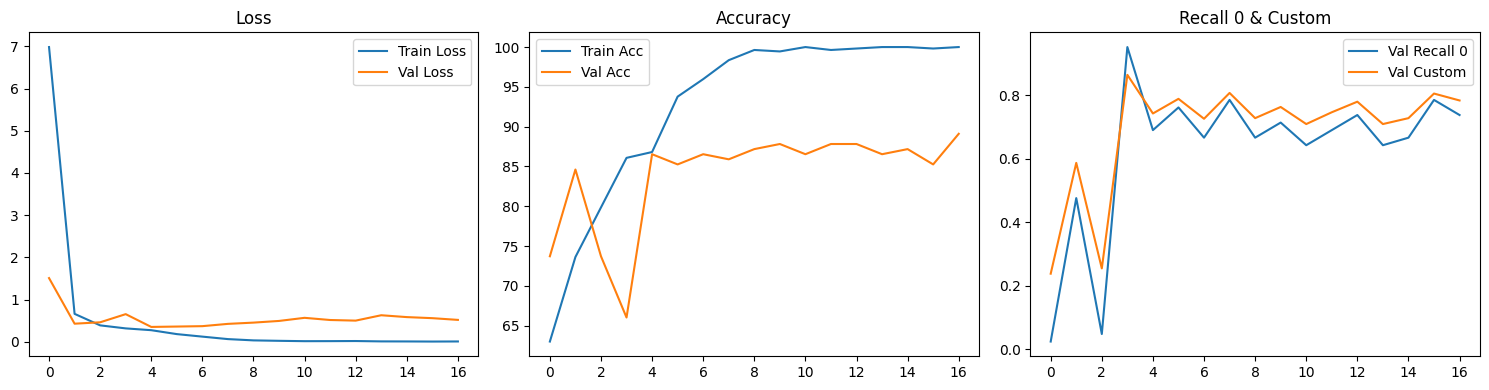


Validation Loss: 0.6994, Accuracy: 87.82%, Recall 0: 0.6905
              precision    recall  f1-score   support

           0       0.83      0.69      0.75        42
           1       0.89      0.95      0.92       114

    accuracy                           0.88       156
   macro avg       0.86      0.82      0.84       156
weighted avg       0.88      0.88      0.87       156



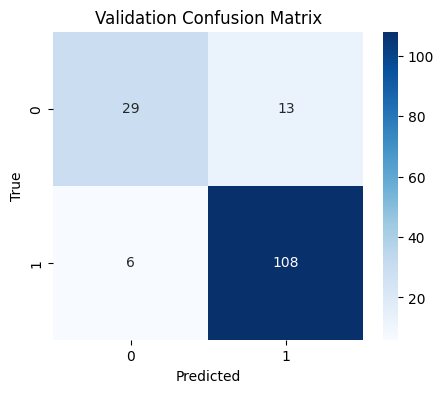

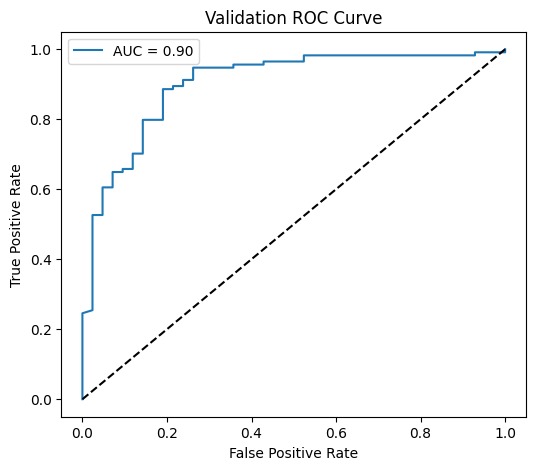


Test Loss: 0.4457, Accuracy: 91.03%, Recall 0: 0.7619
              precision    recall  f1-score   support

           0       0.89      0.76      0.82        21
           1       0.92      0.96      0.94        57

    accuracy                           0.91        78
   macro avg       0.90      0.86      0.88        78
weighted avg       0.91      0.91      0.91        78



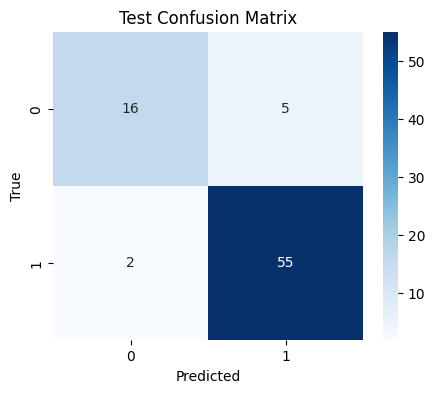

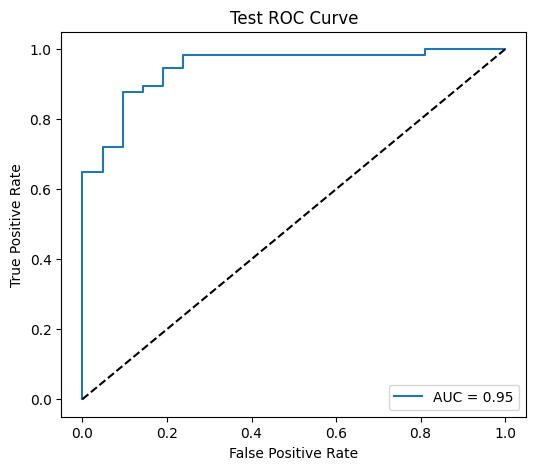



==================== RECALL0 ====================
Best Hyperparameters: {'lr': 0.001, 'activation_fn': 'LeakyReLU', 'weight_decay': 0.01}


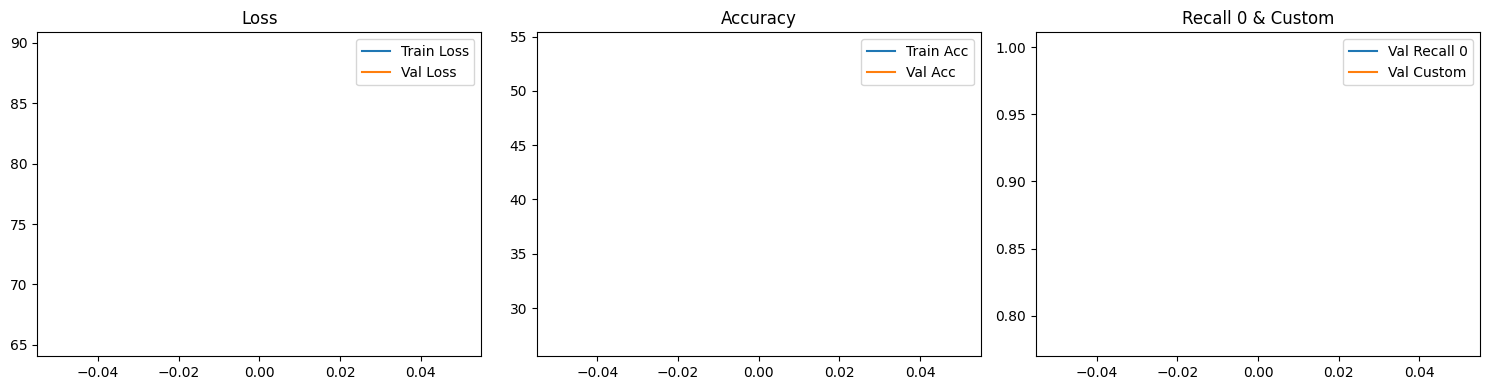


Validation Loss: 0.4109, Accuracy: 85.26%, Recall 0: 0.5000
              precision    recall  f1-score   support

           0       0.91      0.50      0.65        42
           1       0.84      0.98      0.91       114

    accuracy                           0.85       156
   macro avg       0.88      0.74      0.78       156
weighted avg       0.86      0.85      0.84       156



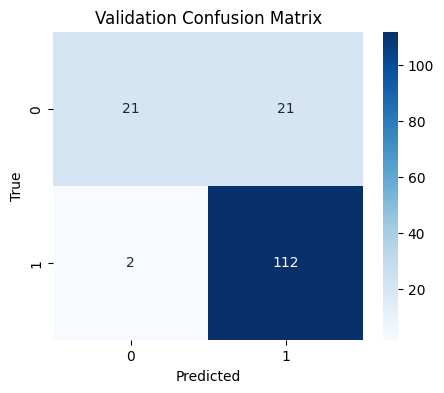

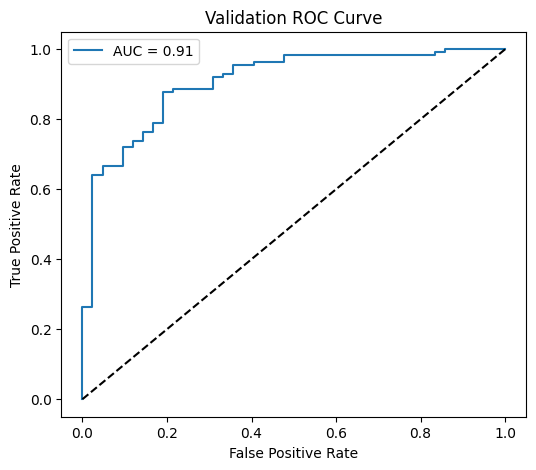


Test Loss: 0.2699, Accuracy: 92.31%, Recall 0: 0.7143
              precision    recall  f1-score   support

           0       1.00      0.71      0.83        21
           1       0.90      1.00      0.95        57

    accuracy                           0.92        78
   macro avg       0.95      0.86      0.89        78
weighted avg       0.93      0.92      0.92        78



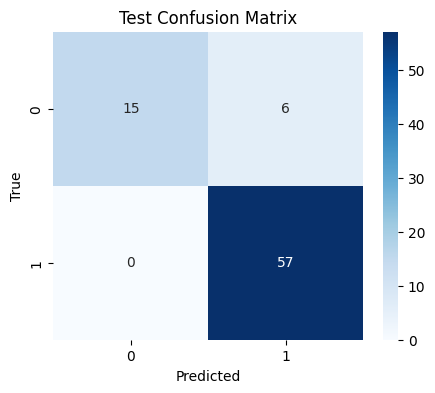

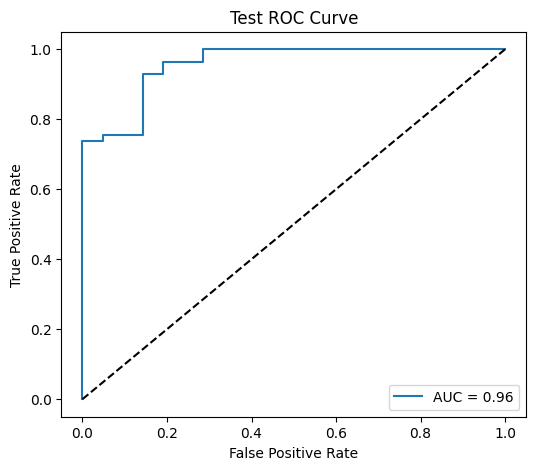



==================== CUSTOM ====================
Best Hyperparameters: {'lr': 0.0001, 'activation_fn': 'ReLU', 'weight_decay': 0.01}


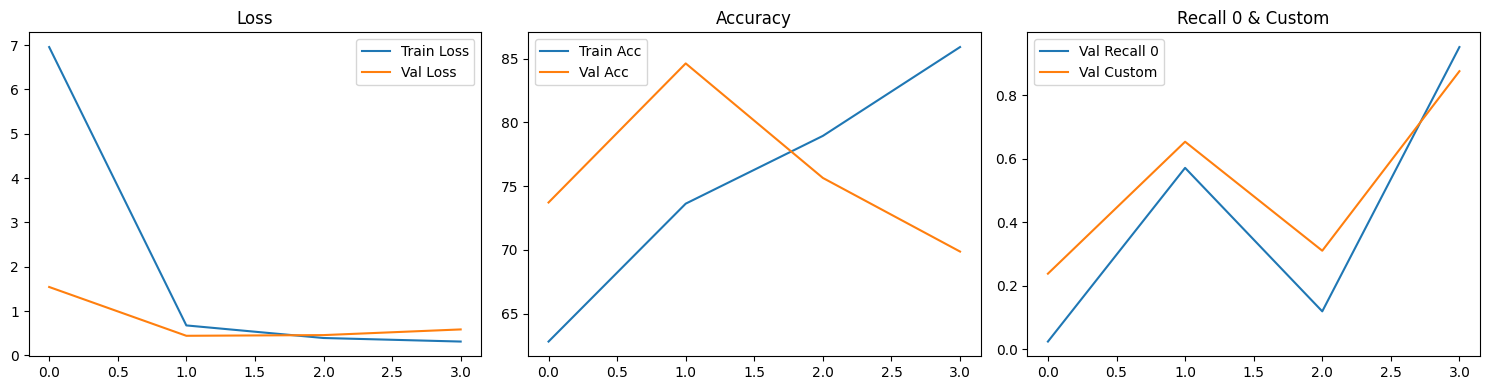


Validation Loss: 0.6144, Accuracy: 87.18%, Recall 0: 0.6667
              precision    recall  f1-score   support

           0       0.82      0.67      0.74        42
           1       0.89      0.95      0.92       114

    accuracy                           0.87       156
   macro avg       0.85      0.81      0.83       156
weighted avg       0.87      0.87      0.87       156



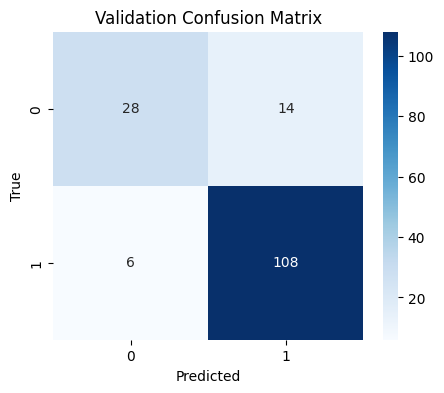

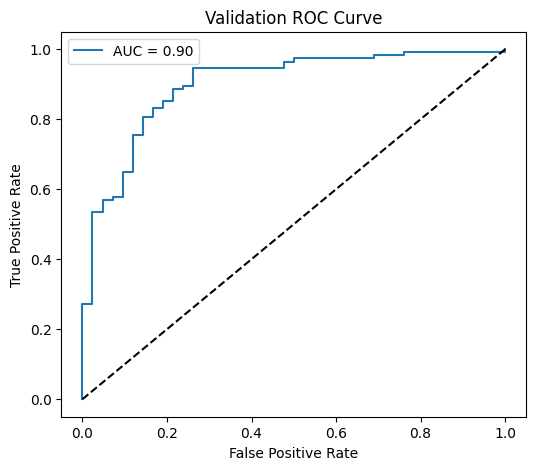


Test Loss: 0.3670, Accuracy: 91.03%, Recall 0: 0.7619
              precision    recall  f1-score   support

           0       0.89      0.76      0.82        21
           1       0.92      0.96      0.94        57

    accuracy                           0.91        78
   macro avg       0.90      0.86      0.88        78
weighted avg       0.91      0.91      0.91        78



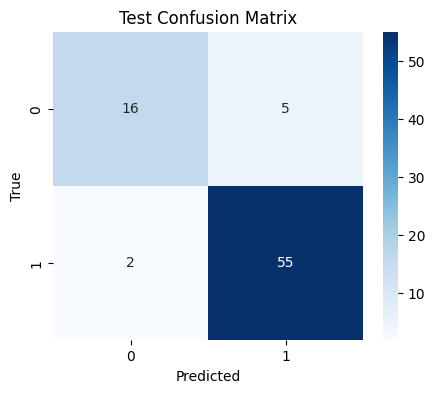

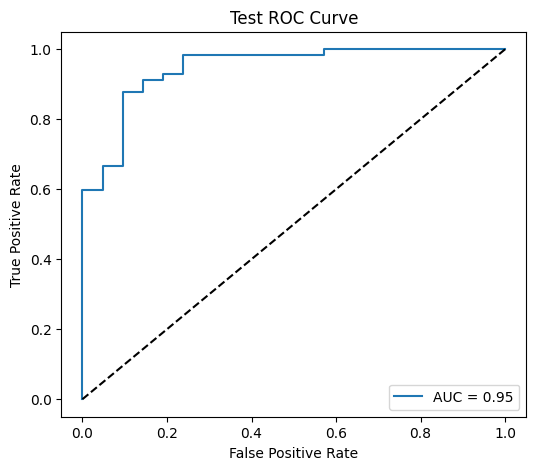

In [7]:
# --- ANALYSIS AFTER ALL TRIALS ---
for metric, info in overall_best.items():
    print(f"\n\n==================== {metric.upper()} ====================")
    print("Best Hyperparameters:", info["params"])
    # Reload best model
    model = CNN(num_classes=len(np.unique(y_train)), activation_fn=info["params"]["activation_fn"])
    model.load_state_dict(info["state"])
    model.to(device)
    train_losses, train_accuracies, val_losses, val_accuracies, val_recalls_0, val_custom_scores = info["history"]
    # Plot loss/accuracy/recall/custom
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1,3,2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1,3,3)
    plt.plot(val_recalls_0, label='Val Recall 0')
    plt.plot(val_custom_scores, label='Val Custom')
    plt.title('Recall 0 & Custom')
    plt.legend()
    plt.tight_layout()
    plt.show()
    # Validation set
    evaluate_and_plot(model, X_val_tensor, y_val_encoded, [str(c) for c in label_encoder.classes_], device, set_name="Validation")
    # Test set
    evaluate_and_plot(model, X_test_tensor, y_test_encoded, [str(c) for c in label_encoder.classes_], device, set_name="Test")